In [42]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta

# Step 1: Fetch Historical Data
def fetch_historical_data(ticker):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=90)
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start_date, end=end_date)
    return hist

# Step 2: Calculate Investment Value Over Time
def calculate_investment_value(hist, initial_amount):
    initial_price = hist['Close'][0]
    shares = initial_amount / initial_price
    hist['Investment Value'] = hist['Close'] * shares
    return hist

# Step 3: Create Animation
def create_animation(hist):
    # Create a list of frames for the animation
    frames = [go.Frame(
        data=[go.Scatter(x=hist.index[:k+1], y=hist['Investment Value'][:k+1], mode='lines')],
        name=f'frame{k}'
    ) for k in range(len(hist))]

    # Define the initial empty data
    initial_data = go.Scatter(x=[], y=[], mode='lines')

    # Calculate overall profit or loss
    start_value = hist['Investment Value'].iloc[0]
    end_value = hist['Investment Value'].iloc[-1]
    profit = end_value - start_value
    color = 'green' if profit > 0 else 'red'
    line_dash = 'dash' if profit > 0 else 'dot'

    # Add a dashed or dotted line from start to end
    profit_line = go.Scatter(
        x=[hist.index[0], hist.index[-1]],
        y=[start_value, end_value],
        mode='lines',
        line=dict(color=color, dash=line_dash),
        name='Profit/Loss Line'
    )

    # Define axis ranges
    y_range = [hist['Investment Value'].min() * 0.95, hist['Investment Value'].max() * 1.05]
    x_range = [hist.index[0], hist.index[-1]]

    # Define the layout with buttons to control the animation
    layout = go.Layout(
        title='Investment Value Over Time',
        xaxis_title='Date',
        yaxis_title='Investment Value ($)',
        xaxis=dict(range=x_range),
        yaxis=dict(range=y_range),
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'buttons': [{
                'label': 'Play',
                'method': 'animate',
                'args': [None, {'frame': {'duration': 100, 'redraw': False}, 'fromcurrent': True}]
            }]
        }]
    )

    # Create the figure with initial data and layout
    fig = go.Figure(data=[initial_data], layout=layout, frames=frames)
    
    # Add the profit/loss line to the final frame
    fig.add_trace(profit_line)
    
    # Show the figure
    fig.show()

# Parameters
ticker = "NVDA"
initial_amount = 152

# Fetch historical data
hist = fetch_historical_data(ticker)

# Calculate investment value over time
hist = calculate_investment_value(hist, initial_amount)

# Create and display animation
create_animation(hist)

In [93]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Fetch historical data
def fetch_historical_data(ticker):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start_date, end=end_date)
    return hist

# Calculate moving averages and volatility
def calculate_features(hist):
    hist['MA20'] = hist['Close'].rolling(window=20).mean()
    hist['MA50'] = hist['Close'].rolling(window=50).mean()
    hist['Volatility'] = hist['Close'].rolling(window=20).std()
    hist.dropna(inplace=True)
    return hist

# Fetch historical data
ticker = "AMZN"
hist = fetch_historical_data(ticker)

# Calculate features
hist = calculate_features(hist)

In [94]:
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM
def prepare_data(hist):
    data = hist[['Close', 'MA20', 'MA50', 'Volatility']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X = []
    y = []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    
    # Define the training and validation sets
    train_size = (len(hist.index) - 60) * 2 // 3  # Approx 4 months of data
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]
    
    return X_train, y_train, X_val, y_val, scaler

X_train, y_train, X_val, y_val, scaler = prepare_data(hist)

In [101]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model((X_train.shape[1], X_train.shape[2]))

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.7686 - val_loss: 0.5396
Epoch 2/50
1/1 [==============================] - 0s 48ms/step - loss: 0.4910 - val_loss: 0.3032
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 0.2879 - val_loss: 0.1191
Epoch 4/50
1/1 [==============================] - 0s 48ms/step - loss: 0.1132 - val_loss: 0.0123
Epoch 5/50
1/1 [==============================] - 0s 50ms/step - loss: 0.0325 - val_loss: 0.0273
Epoch 6/50
1/1 [==============================] - 0s 48ms/step - loss: 0.0566 - val_loss: 0.0872
Epoch 7/50
1/1 [==============================] - 0s 48ms/step - loss: 0.1133 - val_loss: 0.0772
Epoch 8/50
1/1 [==============================] - 0s 52ms/step - loss: 0.1080 - val_loss: 0.0357
Epoch 9/50
1/1 [==============================] - 0s 49ms/step - loss: 0.0714 - val_loss: 0.0066
Epoch 10/50
1/1 [==============================] - 0s 53ms/step - loss: 0.0317 - val_loss: 0.0033
Epoch 11/50
1/1 [==============

In [105]:
model.save('invest_pred.keras')

1/1 [==============================] - 0s 20ms/step


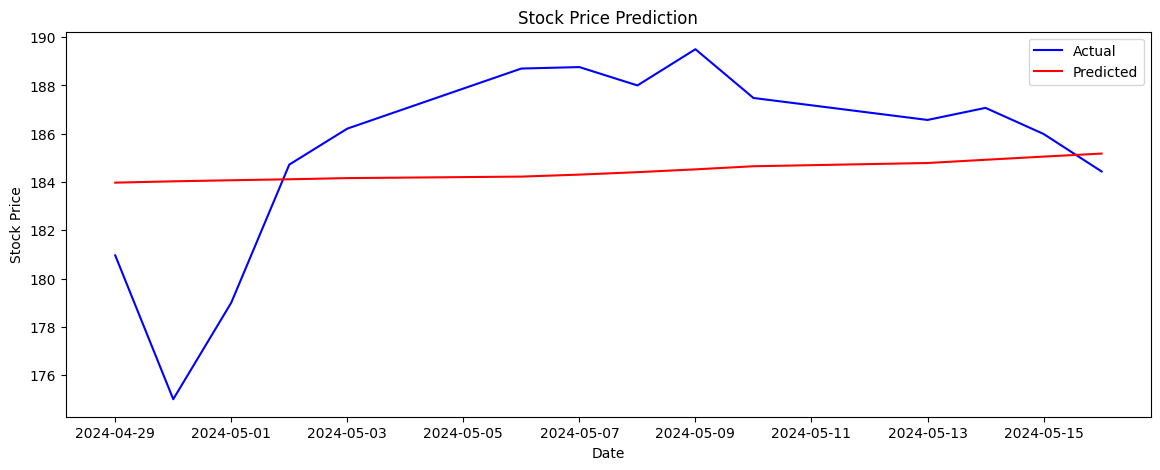

In [107]:
import matplotlib.pyplot as plt

# Prepare the test data for making predictions
data = hist[['Close', 'MA20', 'MA50', 'Volatility']].values
scaled_data = scaler.transform(data)

def prepare_test_data(hist, scaler):  
    X_test = []
    for i in range(60, len(scaled_data)):
        X_test.append(scaled_data[i-60:i])
    
    X_test = np.array(X_test)
    return X_test

# Make predictions
X_test = prepare_test_data(hist, scaler)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 3)))))[:, 0]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(hist.index[-len(predictions):], hist['Close'][-len(predictions):], color='blue', label='Actual')
plt.plot(hist.index[-len(predictions):], predictions, color='red', label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [110]:
from tensorflow.keras.models import load_model

# Step 5: Make Predictions for Next 30 Days
def predict_next_30_days(model, data, scaler):
    last_60_days = data[-60:]
    predicted_prices = []
    for _ in range(30):
        x_input = last_60_days[-60:].reshape(1, -1, 1)
        predicted_price = model.predict(x_input)
        predicted_prices.append(predicted_price)
        last_60_days = np.append(last_60_days, predicted_price)[1:]
    predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))
    return predicted_prices

def extend_animation(hist, predicted_prices):
    future_dates = pd.date_range(start=hist.index[-1], periods=31, closed='right')
    future_investment_values = predicted_prices.flatten() * (initial_amount / hist['Close'][0])
    future_hist = pd.DataFrame(data={'Close': predicted_prices.flatten(), 'Investment Value': future_investment_values}, index=future_dates)
    extended_hist = pd.concat([hist, future_hist])

    # Create a list of frames for the animation
    frames = [go.Frame(
        data=[go.Scatter(x=extended_hist.index[:k+1], y=extended_hist['Investment Value'][:k+1], mode='lines')],
        name=f'frame{k}'
    ) for k in range(len(extended_hist))]

    # Define the initial empty data
    initial_data = go.Scatter(x=[], y=[], mode='lines')

    # Calculate overall profit or loss
    start_value = extended_hist['Investment Value'].iloc[0]
    end_value = extended_hist['Investment Value'].iloc[-1]
    profit = end_value - start_value
    color = 'green' if profit > 0 else 'red'
    line_dash = 'dash' if profit > 0 else 'dot'

    # Add a dashed or dotted line from start to end
    profit_line = go.Scatter(
        x=[extended_hist.index[0], extended_hist.index[-1]],
        y=[start_value, end_value],
        mode='lines',
        line=dict(color=color, dash=line_dash),
        name='Profit/Loss Line'
    )

    # Define axis ranges
    y_range = [extended_hist['Investment Value'].min() * 0.95, extended_hist['Investment Value'].max() * 1.05]
    x_range = [extended_hist.index[0], extended_hist.index[-1]]

    # Define the layout with buttons to control the animation
    layout = go.Layout(
        title='Investment Value Over Time',
        xaxis_title='Date',
        yaxis_title='Investment Value ($)',
        xaxis=dict(range=x_range),
        yaxis=dict(range=y_range),
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'buttons': [{
                'label': 'Play',
                'method': 'animate',
                'args': [None, {'frame': {'duration': 100, 'redraw': False}, 'fromcurrent': True}]
            }]
        }]
    )

    # Create the figure with initial data and layout
    fig = go.Figure(data=[initial_data], layout=layout, frames=frames)
    
    # Add the profit/loss line to the final frame
    fig.add_trace(profit_line)
    
    # Show the figure
    fig.show()

# Extend the animation with the predicted data
extend_animation(hist, predict_next_30_days(load_model('invest_pred.keras'), scaled_data, scaler))

ValueError: in user code:

    File "c:\Users\golde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\golde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\golde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\golde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\golde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\golde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 60, 4), found shape=(None, 240, 1)
